# 2019-07-08 spyros without fetal & hybrid cells

In [1]:
import pandas as pd
import numpy as np
import loompy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import matplotlib as mpl
import imp
import sys
sys.path.append('/home/bojk/Data/minimeta_pyfiles/')
import leidenalgorithm_implementation as li
import semiannotate 

In [2]:
# load data
# darmanis brain atlas
BA_count_path = '../leidenalg/Datasets/Darmanis_Brain/All_cell_counts_brain.csv'
BA_counttable = pd.read_csv(BA_count_path,index_col=0)
BA_meta = pd.read_csv('../leidenalg/Datasets/Darmanis_Brain/All_cell_info_brain.csv',sep=';',index_col=0)

#darmanis glioblastoma dataset (to annotate based on brain atlas)
GBM_count_path = '../leidenalg/Datasets/Darmanis_Glioblastoma/GBM_data_and_metadata/GBM_raw_gene_counts.csv'
GBM_counttable = pd.read_csv(GBM_count_path,sep=' ',index_col=0)
GBM_meta = pd.read_csv('../leidenalg/Datasets/Darmanis_Glioblastoma/GBM_data_and_metadata/GBM_metadata.csv',sep=' ',index_col=0)
GBMtsne = pd.read_csv('../leidenalg/Datasets/Darmanis_Glioblastoma/GBM_data_and_metadata/GBM_TSNE.csv',sep=' ',index_col=0)
GBM_meta = GBM_meta.join(GBMtsne)
# add annotation from separate file
GBMmeta2= pd.read_csv('../leidenalg/Datasets/Darmanis_Glioblastoma/GBM_data_and_metadata/GEO_upload/spyros.darmanis_metadata_GBM.csv',index_col=0)
GBM_meta = GBM_meta.join(GBMmeta2['characteristics: cell type'])
GBM_meta.rename(index=str,columns={'characteristics: cell type':'Cell_type2'},inplace=True)

lut = {'Astocyte':'Astrocytes','Neuron':'Neurons','Oligodendrocyte':'Oligodendrocytes','Vascular':'Endothelial'
       ,'Immune cell':'Immune cell', 'Neoplastic':'Neoplastic','OPC':'OPC'}

GBM_meta['Cell_type'] = GBM_meta['Cell_type2'].map(lut)

In [3]:
idx_fetal = list(BA_meta[~BA_meta.Cell_type.str.contains('Fetal')].index)
BA_newmet = BA_meta[BA_meta.index.isin(idx_fetal)].copy()# no fetal cells 
idx_hyb = list(BA_newmet[~BA_newmet.Cell_type.str.contains('ybrid')].index)
BA_newmeta = BA_newmet[BA_newmet.index.isin(idx_hyb)].copy()# no hybrid cells 
BA_newcounts = BA_counttable[BA_newmeta.index].copy()

# feature select first run

In [38]:
import get_timestamp as time

imp.reload(li)
keys = ['cell type column','number of features cell type','number of features new data']
values = ['Cell_type',0,500]
kwds = dict(zip(keys,values))
matrix,weights, BA_meta,GBM_meta = li.normmerge_twoCounttables(BA_newcounts,
                                                                             BA_newmeta, GBM_counttable, GBM_meta, **kwds)

imp.reload(li)
matrix_feature_selected = li.feature_select(matrix.dropna(how='all',axis=1),BA_meta,**kwds)

-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5']
-------------------------------------------
-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5', 'ERCC1', 'ERCC2', 'ERCC3', 'ERCC4', 'ERCC5', 'ERCC6', 'ERCC6L', 'ERCC8']
-------------------------------------------
-------------------------------------------
Cell types in atlas:
['Astrocytes' 'Endothelial' 'Microglia' 'Neurons' 'OPC' 'Oligodendrocytes']
-------------------------------------------
Cell types in new data:
['Astrocytes' 'Endothelial' 'Immune cell' 'Neoplastic' 'Neurons' 'OPC'
 'Oligodendrocytes']
-------------------------------------------
no atlas genes or classes included
-------------------------------------------
Selected number of genes from new cells:
500
-------------------------------------------
Combined total of selected genes:
500
-------------------------------------------


# no self edging, no atlas genes

In [7]:
imp.reload(li)
date = time.datenum_complete()
keys = ['cell type column','number of features cell type','number of features new data',
        'threshold_neigborhood','n_pcs','resolution_parameter','self_edging']
values = ['Cell_type',0,500,.8,20,.001,False]
kwds = dict(zip(keys,values))
tsnedf, class_numbers,vals,wdm = li.semiAnnotate_to_pca_to_tsnedf(matrix_feature_selected,weights,BA_newmeta,GBM_meta,**kwds)

-------------------------------------------
perfoming weighted PCA
-------------------------------------------
perfoming tSNE
assigned default perplexity of 20
tSNE done.
-------------------------------------------
-------------------------------------------
perfoming UNweighted PCA
-------------------------------------------
perfoming tSNE
tSNE done.
-------------------------------------------


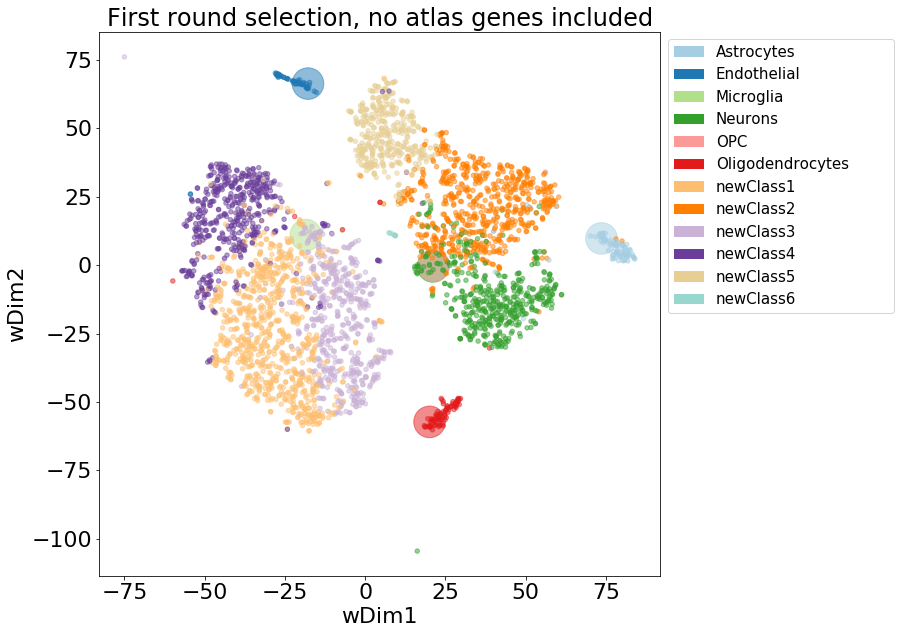

In [11]:
newlut = dict(zip(class_numbers,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(class_numbers)-10)))
newcolor = tsnedf['class'].map(newlut)
n_pcs = kwds['n_pcs']
thresn = kwds['threshold_neigborhood']
respar = kwds['resolution_parameter']
f,ax = plt.subplots(figsize=(12,10))
tsnedf.plot.scatter('wDim1','wDim2',s=weights*20
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,vals,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, no atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/semiAnnotate_nofetal_nose_______lfEdges_equalweight_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')

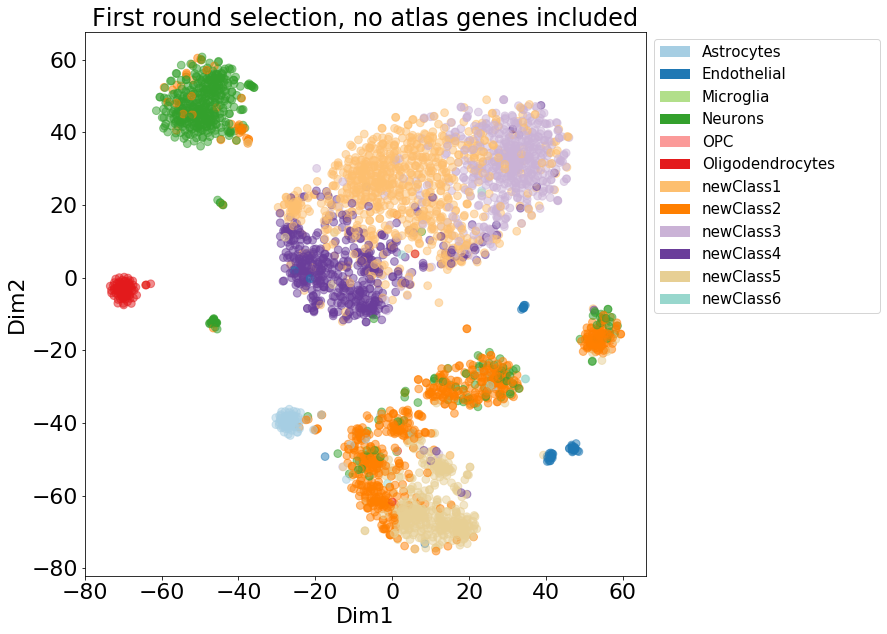

In [12]:
idx = tsnedf[6:].index
GBM_meta.loc[idx,'new_membership'] = tsnedf.iloc[6:]['new_membership']
# new results mapped onto old tSNE
newlut = dict(zip(vals,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(vals)-10)))
newcolor = GBM_meta['new_membership'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
GBM_meta.plot.scatter('Dim1','Dim2',s=60
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, no atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/semiAnnotate_nofetal_noselfEdges_equalweight_origtSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')

# no self-edging, with atlas genes


In [50]:
import json
output_file = '../leidenalg/Datasets/Darmanis_Brain/parameters'+date+'.json'
with open(output_file,'w') as file:
    file.write(json.dumps(kwds))
    file.close()

In [107]:
import get_timestamp as time
date = time.datenum_complete()
savedir = '../leidenalg/Datasets/Darmanis_Brain/'
atlasgenes = 20
atlasweights = 60
imp.reload(li)
keys = ['cell type column','number of features cell type','number of features new data'
        ,'weights_atlas_cells','timestamp','savedir']
values = ['Cell_type',atlasgenes,400,atlasweights,date,savedir]
kwds = dict(zip(keys,values))
matrix,weights, BA_meta,GBM_meta = li.normmerge_twoCounttables(BA_newcounts,
                                                                             BA_newmeta, GBM_counttable, GBM_meta, **kwds)
matrix_feature_selected = li.feature_select(matrix.dropna(how='all',axis=1),BA_meta,**kwds)

kwds['threshold_neigborhood'] = thresn = .8  
kwds['n_pcs'] = n_pcs = 20 
kwds['resolution_parameter'] = respar = .0012 
kwds['self_edging'] = False

tsnedf, class_numbers,vals,wdm = li.semiAnnotate_to_pca_to_tsnedf(matrix_feature_selected,weights,BA_newmeta,GBM_meta,**kwds)

-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5']
-------------------------------------------
-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5', 'ERCC1', 'ERCC2', 'ERCC3', 'ERCC4', 'ERCC5', 'ERCC6', 'ERCC6L', 'ERCC8']
-------------------------------------------
-------------------------------------------
Cell types in atlas:
['Astrocytes' 'Endothelial' 'Microglia' 'Neurons' 'OPC' 'Oligodendrocytes']
-------------------------------------------
Cell types in new data:
['Astrocytes' 'Endothelial' 'Immune cell' 'Neoplastic' 'Neurons' 'OPC'
 'Oligodendrocytes']
-------------------------------------------
-------------------------------------------
Selected number of genes from atlas:
120
-------------------------------------------
Selected number of genes from new cells:
400
-------------------------------------------
Combined total of selected genes:
515
-------------------------------------------
--

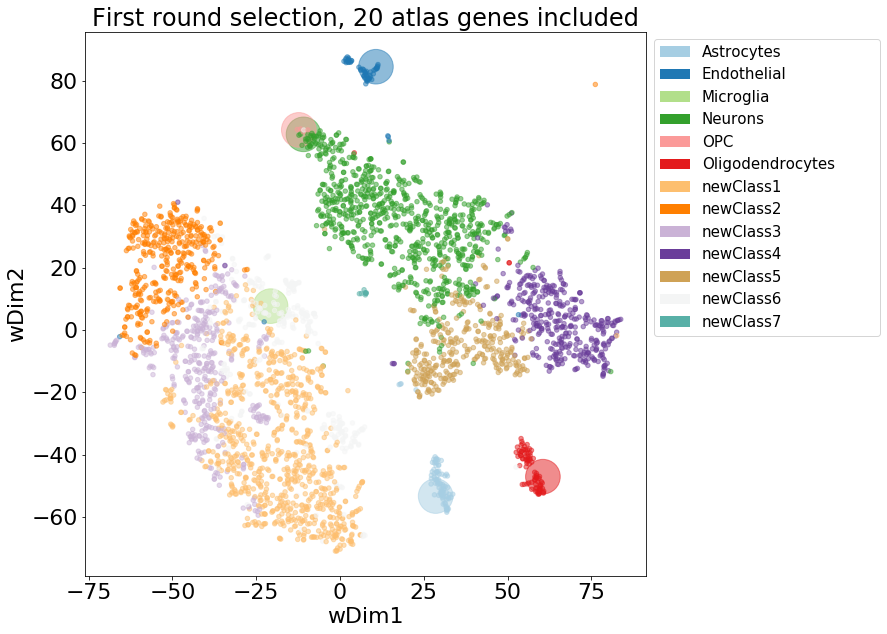

In [108]:
newlut = dict(zip(class_numbers,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(class_numbers)-10)))
newcolor = tsnedf['class'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
tsnedf.plot.scatter('wDim1','wDim2',s=weights*20
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,vals,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_nofetal_noselfEdges_equalweight_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')

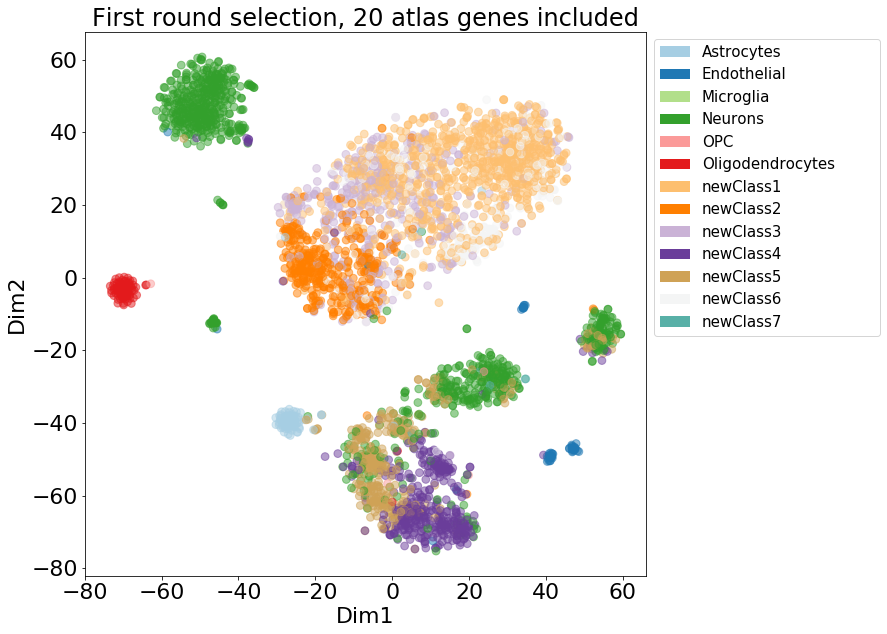

In [109]:
idx = tsnedf[6:].index
GBM_meta.loc[idx,'new_membership'] = tsnedf.iloc[6:]['new_membership']
# new results mapped onto old tSNE
newlut = dict(zip(vals,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(vals)-10)))
newcolor = GBM_meta['new_membership'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
GBM_meta.plot.scatter('Dim1','Dim2',s=60
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_nofetal_noselfEdges_equalweight_origtSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')

# with self-edging

In [110]:
#imp.reload(li)
#imp.reload(semiannotate)
kwds['self_edging'] = True
tsnedfSE, class_numbersSE,valsSE,wdmSE = li.semiAnnotate_to_pca_to_tsnedf(matrix_feature_selected,weights,BA_newmeta,GBM_meta,**kwds)   

-------------------------------------------
perfoming weighted PCA
-------------------------------------------
perfoming tSNE
assigned default perplexity of 20
tSNE done.
-------------------------------------------
-------------------------------------------
perfoming UNweighted PCA
-------------------------------------------
perfoming tSNE
tSNE done.
-------------------------------------------


In [111]:
tsnedfSE['new_membership'].value_counts()
#tsnedfSE['original_membership'].value_counts()

newClass1           957
newClass2           596
newClass3           545
newClass4           439
newClass5           355
newClass6           285
Neurons             151
Astrocytes           94
Oligodendrocytes     84
Endothelial          42
OPC                  38
newClass7             8
Microglia             1
Name: new_membership, dtype: int64

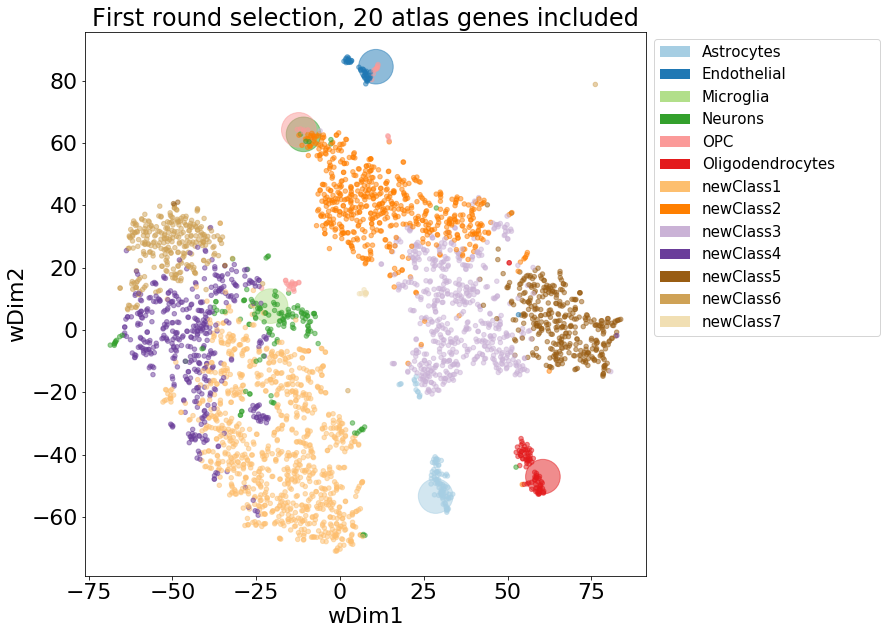

In [112]:
newlut = dict(zip(class_numbersSE,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(class_numbers)-6)))
newcolor = tsnedfSE['class'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
tsnedfSE.plot.scatter('wDim1','wDim2',s=weights*20
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,valsSE,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotateSE_nofetal_selfEdges_weightsEq_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')

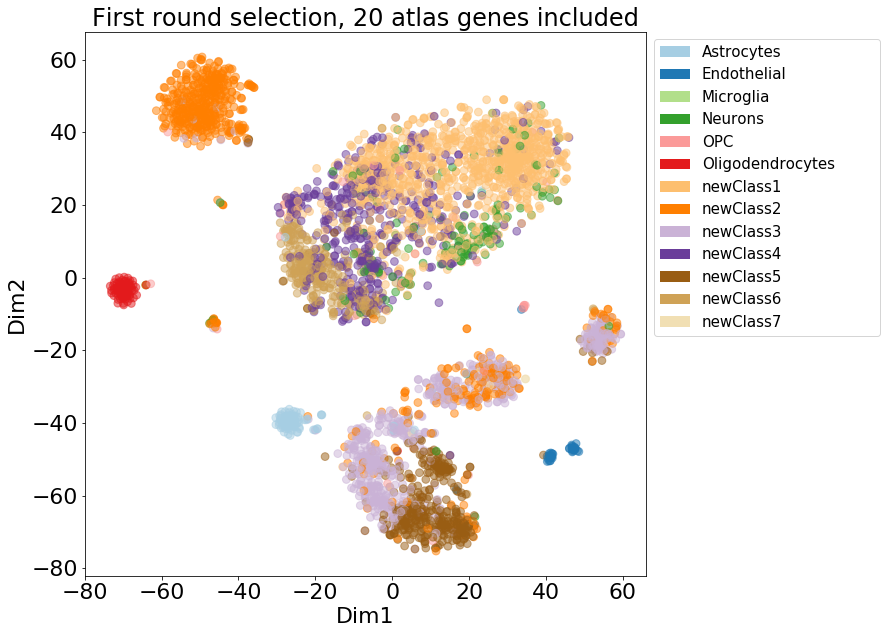

In [113]:
idx = tsnedf[6:].index
GBM_meta.loc[idx,'new_membershipSE'] = tsnedfSE.iloc[6:]['new_membership']
# new results mapped onto old tSNE
newlut = dict(zip(valsSE,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(valsSE)-6)))
newcolor = GBM_meta['new_membershipSE'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
GBM_meta.plot.scatter('Dim1','Dim2',s=60
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_nofetal_selfEdges_equalweight_origtSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')

# check stability - this re-initializes semiAnnotate(!)

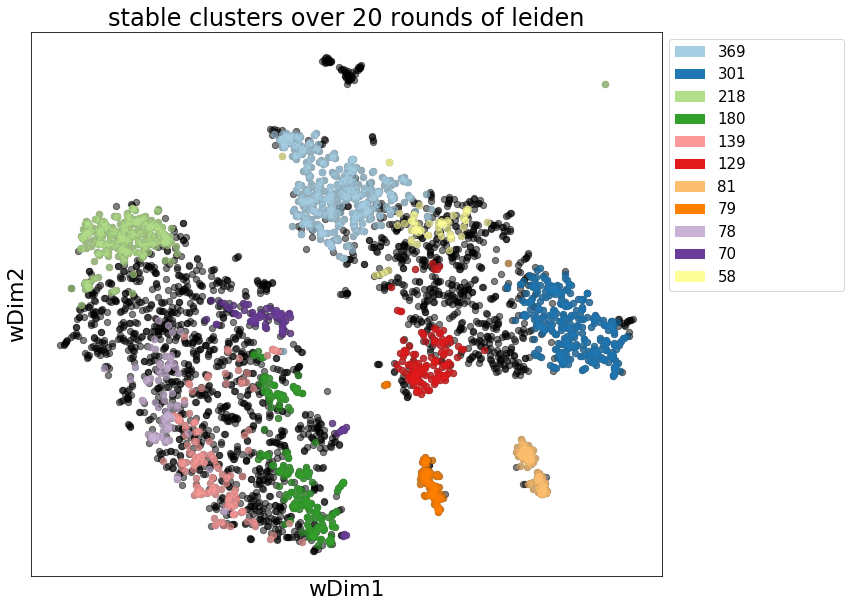

In [158]:
# uses same dict as above

dim = len(matrix_feature_selected.T)
trials = 20
b = c = np.ndarray([trials,dim,dim],np.int32)


for i in range(trials):
    #values = ['Cell_type',30,500,.8,20,respar[i],True]
    
    #ts, class_numSE,valSE,wdmSE= li.semiAnnotate_to_pca_to_tsnedf(matrix_feature_selected,weights,BA_newmeta,GBM_meta,**kwds)
    ts, class_numSE,valSE = li.semiAnnotate_using_tsnedf(matrix_feature_selected,weights,BA_newmeta,GBM_meta,tsnedfSE,**kwds)
    newdf2 = ts.copy()
    newdf2['class2'] = newdf2['class']+1
    df = pd.pivot_table(newdf2,values='class2',index=newdf2.index,columns='new_membership',aggfunc=np.count_nonzero).fillna(0).copy()                     
    a = df.T.corr().values
    b[i][:][:] = a
    #c[i][:][:] = np.corrcoef(a)

    
average_df = pd.DataFrame(np.average(b,axis=0),index=df.index,columns=df.index)
#average_corr = pd.DataFrame(np.average(c,axis=0),index=df.index,columns=df.index)
drop_idx = average_df[(average_df[average_df==1].sum()==1)].index
stable_pairs = average_df.drop(drop_idx).drop(drop_idx,axis=1)
stablep = stable_pairs[stable_pairs==1].fillna(0)

# select groups with same size as value counts (this avoids me having to perform hierarchical clustering)
idx = stablep.sum().value_counts().index.astype(int)
val = stablep.sum().value_counts().values
df = pd.DataFrame(index=range(len(idx)), columns=['idx','val'])
df['idx'] = idx;df['val'] = val
groups = df[df.eq(df.iloc[:, 0], axis=0).all(1)==True].idx.values

idxs = []
for cluster in groups:
    idxs.append(list(stablep[stablep.sum()==cluster].index))
clusterdict = dict(zip(groups,idxs))


len(groups)
groupi = groups[:11] # take the 11 largest groups



values = sns.color_palette('Paired',len(groupi))
lut = dict(zip(groupi,values))

f,ax = plt.subplots(figsize=(12,10))

tsnedfSE.plot.scatter('wDim1','wDim2',ax=ax,color='k',s=2*20,alpha=.5)
for group in groupi:
    idxes = clusterdict[group]
    tsnedfSE.loc[idxes].plot.scatter('wDim1','wDim2',ax=ax,color=lut[group],s=40,alpha=.6)

for x,y in lut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
    plt.legend(handles[:],labels[:],bbox_to_anchor=(1, .9, .3, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.yticks([]);plt.xticks([])
plt.title('stable clusters over '+str(trials)+' rounds of leiden')
plt.gcf().subplots_adjust(left=.05,right=0.78)
plt.show()
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotateStability'+date+'.png')

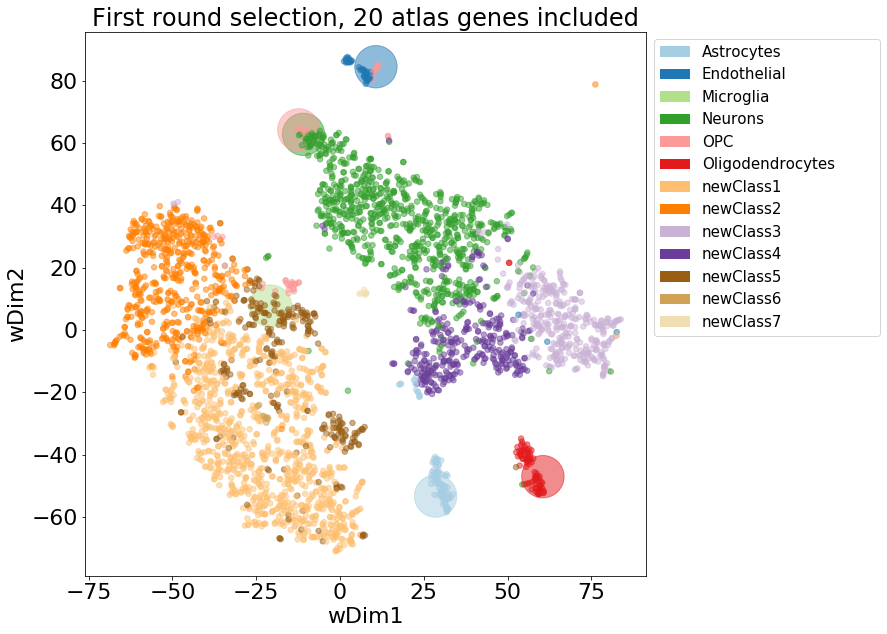

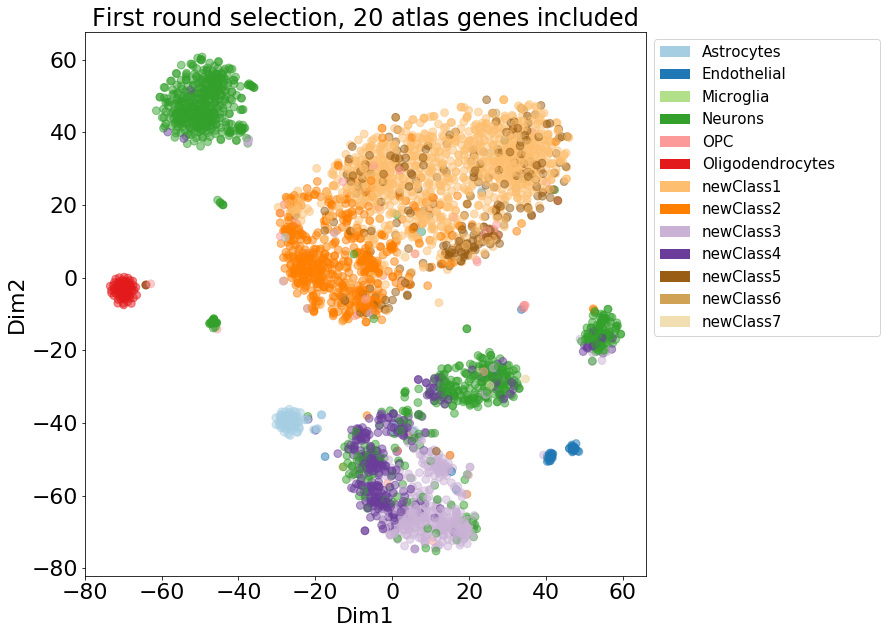

In [159]:
#post stability classes
newlut = dict(zip(valSE,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(valSE)-6)))
newcolor = ts['new_membership'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
ts.plot.scatter('wDim1','wDim2',s=weights*30
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,valSE,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotateSE_nofetal_selfEdges_weightsEq_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'_postStab.png')

idx = tsnedf[6:].index
GBM_meta.loc[idx,'new_membershipSE_postStab'] = ts.iloc[6:]['new_membership']
# new results mapped onto old tSNE
newlut = dict(zip(valSE,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(valSE)-6)))
newcolor = GBM_meta['new_membershipSE_postStab'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
GBM_meta.plot.scatter('Dim1','Dim2',s=60
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_nofetal_selfEdges_equalweight_origtSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'_postStab.png')

In [168]:
from scipy.spatial.distance import squareform
len(squareform(1-average_df))

6460215

In [183]:
def make_pairdf(correlation_matrix,NN,tsne_df):
    pairs = li.make_pairs(correlation_matrix,2,NN)
    pair_df = pd.DataFrame(pairs)
    for pair in pair_df.index:
        cell1 = pair_df.loc[pair,0]
        cell2 = pair_df.loc[pair,1]
        class1 = tsne_df.loc[cell1,'new_membership']
        class2 = tsne_df.loc[cell2,'new_membership']
        if class1==class2:
            pair_df.loc[pair,'edge_type'] = 'inter_class'
        else:
            pair_df.loc[pair,'edge_type'] = 'intra_class'
        pair_df.loc[pair,'correlation'] = 1 - correlation_matrix.loc[cell1,cell2]
        pair_df.loc[pair,'distance'] = correlation_matrix.loc[cell1,cell2]
        xy1 = tsne_df.loc[cell1][['wDim1','wDim2']]
        xy2 = tsne_df.loc[cell2][['wDim1','wDim2']]
        pair_df.loc[pair,'edge_length'] =  np.sqrt((xy2[0]-xy1[0])**2+(xy2[1]-xy1[1])**2)
    return pair_df

In [205]:
cluster_pair_df = make_pairdf(1-average_df,2,ts)


---------------------------------------
Making list of edges with -100% correlation and up
Max 2 edges per cell.
Found 3595 edges.
---------------------------------------


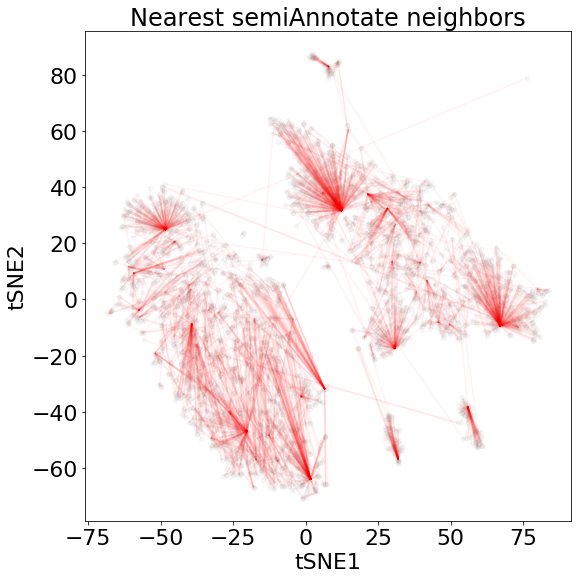

In [210]:
cluster_pair_df#.correlation.sort_values()
#pairs_wSE_95 = li.make_pairs(pd.DataFrame(wdmSE),.05,5)
#olors = sns.color_palette('RdBu_r',5)
f,ax = plt.subplots(figsize=(10,10))
ts.plot.scatter('wDim1','wDim2',figsize=(10,10),ax=ax,alpha=.05,color='gray')
for pair in cluster_pair_df.index:
    xy1 = ts.loc[cluster_pair_df.loc[pair,0]][['wDim1','wDim2']]
    xy2 = ts.loc[cluster_pair_df.loc[pair,1]][['wDim1','wDim2']]
    corr = pairdf.loc[pair,'correlation']
    ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.05
            ,c='r')

#plt.yticks([]);plt.xticks([])
plt.xlabel('tSNE1'),plt.ylabel('tSNE2')
plt.title('Nearest semiAnnotate neighbors')

plt.gcf().subplots_adjust(right=0.8,bottom=.2)
plt.show()
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/brain_edges_clusterCorr_tsne'+date+'.png')

In [200]:
(1-average_df).iloc[0].sort_values()[1:2]

1001000238.E3    0.0
Name: 1001000010.B4, dtype: float64

In [207]:
ts

wDim1      wDim2  class original_membership  \
Astrocytes        28.540468 -53.282181      0                 NaN   
Endothelial       10.718905  84.519669      1                 NaN   
Microglia        -20.719158   7.680630      2                 NaN   
Neurons          -10.892129  62.822136      3                 NaN   
OPC              -12.299467  64.247383      4                 NaN   
Oligodendrocytes  60.552765 -47.058403      5                 NaN   
1001000173.G8     53.824368  21.808517      3          Neoplastic   
1001000173.D4     55.855118 -36.736149      5    Oligodendrocytes   
1001000173.B4     68.367439   4.812644      8          Neoplastic   
1001000173.A2     34.725250  -2.522209      9          Neoplastic   
1001000173.E2     50.687931   8.481841      8          Neoplastic   
1001000173.F6     40.068008  -9.433475      9          Neoplastic   
1001000173.B12    63.044163  11.699169      8          Neoplastic   
1001000173.D6     54.384384  15.796387      8                 OPC   
1001000173.H1     79.608826   1.217946      8          Neoplastic   
1001000173.E4     66.920433  12.040787      8          Neoplastic   
1001000173.B6    -10.380634 -52.557098      6         Immune cell   
1001000173.C2     37.228996  -5.026555      9          Neoplastic   
1001000173.F4     59.458954   1.369279      8          Neoplastic   
1001000173.E10    44.486317  -5.302146      9          Neoplastic   
1001000173.E6     27.177214 -13.111617      9          Neoplastic   
1001000173.C4     60.136314  16.632492      8          Neoplastic   
1001000173.B1     50.504028  21.575548      5    Oligodendrocytes   
1001000173.B10    49.655338  -6.136165      9          Neoplastic   
1001000173.A7     34.492756   9.396570      9          Neoplastic   
1001000173.B8     30.870943  -4.294651      9          Neoplastic   
1001000173.F9     18.867010  14.280359      3          Neoplastic   
1001000173.G6     52.277939 -14.338794      9          Neoplastic   
1001000173.A9     75.065086  -2.688699      8          Neoplastic   
1001000173.D2     29.511633 -19.354380      9          Neoplastic   
...                     ...        ...    ...                 ...   
1001000268.G1     28.278240   8.417828      3          Neoplastic   
1001000270.G1      0.236056 -50.274551     10         Immune cell   
1001000270.D12   -42.922035 -23.000608      6         Immune cell   
1001000270.H8    -20.820440 -55.620789      6         Immune cell   
1001000270.A2     -0.322882 -31.020727     10         Immune cell   
1001000270.G3    -17.668552 -55.300667      6         Immune cell   
1001000270.F4     82.613281  -1.774958      6         Immune cell   
1001000270.H6     -0.456818 -44.025311      6         Immune cell   
1001000270.D1    -36.273392 -31.881777      6         Immune cell   
1001000270.H2    -14.878215 -57.635307      6         Immune cell   
1001000270.A10   -38.201138 -10.508729      6         Immune cell   
1001000270.E12   -13.200878 -22.501223      6         Immune cell   
1001000270.F10   -21.775055 -53.785950      6         Immune cell   
1001000270.E10    -1.508960 -34.579403     10         Immune cell   
1001000270.B4    -16.163559 -53.378403      6         Immune cell   
1001000270.C1    -11.239287 -49.605762      6         Immune cell   
1001000270.D7    -34.334904   5.913813     10         Immune cell   
1001000270.H3    -28.419434 -39.857857      6         Immune cell   
1001000270.D9      3.428812  86.436043      1         Endothelial   
1001000271.B3      3.129452  85.946762      1         Endothelial   
1001000271.C2      1.826259  87.254745      1         Endothelial   
1001000271.D1      2.590066  86.923904      1         Endothelial   
1001000271.B1     31.146540  16.889368      3          Neoplastic   
1001000271.A3     34.542862  11.871370      3          Neoplastic   
1001000271.E1      1.176067  86.275475      1         Endothelial   
1001000271.F1      1.819271  85.827934      1         Endothelial   
1001000271.D4    -62

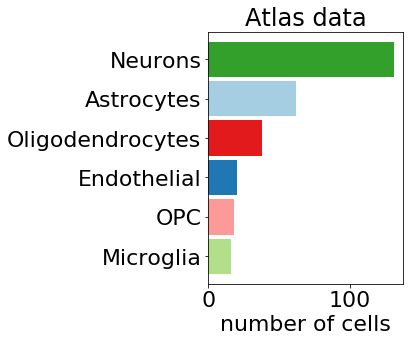

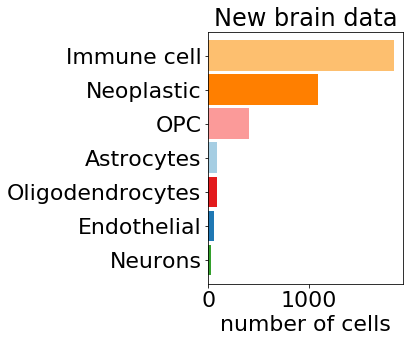

In [279]:
f,ax = plt.subplots(figsize=(6,5))
newlut = dict(zip(np.sort(BA_newmeta['Cell_type'].unique()),sns.color_palette('Paired',len(BA_newmeta['Cell_type'].unique()))))
colors = BA_newmeta['Cell_type'].value_counts().index.map(newlut)
BA_newmeta['Cell_type'].value_counts().plot.barh(width=.9,ax=ax,color=colors)
plt.gca().invert_yaxis()
plt.title('Atlas data')
plt.xlabel('number of cells')
plt.gcf().subplots_adjust(left=.5,right=0.95,bottom=.2,top=.9)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/BrainAtlas_data_original_cellNumBarh.png')

f,ax = plt.subplots(figsize=(6,5))
colors = GBM_meta['Cell_type'].value_counts().index.map(lut)
GBM_meta['Cell_type'].value_counts().plot.barh(width=.9,color=colors,ax=ax)
plt.gca().invert_yaxis()
plt.xlabel('number of cells')
plt.title('New brain data')
plt.gcf().subplots_adjust(left=.5,right=0.95,bottom=.2,top=.9)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/GBM_data_original_cellNumBarh.png')

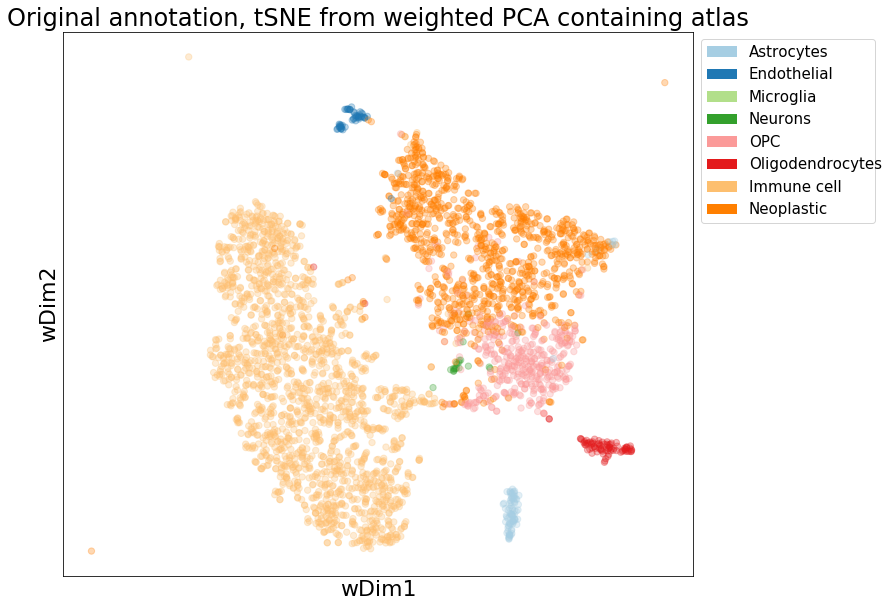

In [292]:
tsnedfSE
newlut
keys = list(tsnedfSE[:6].index)+list(set(tsnedfSE.iloc[6:]['original_membership']).difference(set(tsnedfSE[:6].index)))
values = sns.color_palette('Paired',len(keys))
lut = dict(zip(keys,values))
colors = tsnedfSE[6:].original_membership.map(lut)

f = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(1,1)
ax = f.add_subplot(gs[0,0])
tsnedfSE[6:].plot.scatter('wDim1','wDim2',ax=ax,color=colors,s=40,alpha=.3)#,label=colors.keys)
for x,y in lut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
    plt.legend(handles[:],labels[:],bbox_to_anchor=(1, .9, .3, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.yticks([]);plt.xticks([])
plt.title('Original annotation, tSNE from weighted PCA containing atlas')
plt.gcf().subplots_adjust(left=.05,right=0.78)
plt.show()
f.savefig('../leidenalg/Datasets/Darmanis_Brain/tSNE_weightedPCA_originalAnnotation'+date+'.png')

In [294]:
lut

{'Astrocytes': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 'Endothelial': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 'Microglia': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 'Neurons': (0.2, 0.6274509803921569, 0.17254901960784313),
 'OPC': (0.984313725490196, 0.6039215686274509, 0.6),
 'Oligodendrocytes': (0.8901960784313725,
  0.10196078431372549,
  0.10980392156862745),
 'Immune cell': (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 'Neoplastic': (1.0, 0.4980392156862745, 0.0)}

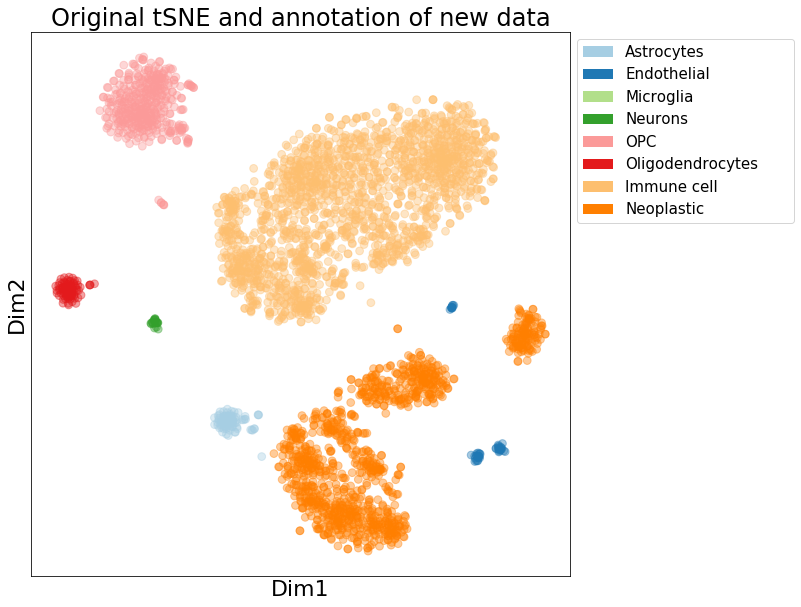

In [300]:
f,ax = plt.subplots(figsize=(11,10))
GBM_meta.plot.scatter('Dim1','Dim2',c=colors,ax=ax,alpha=.4,s=60)

for x,y in lut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.yticks([]);plt.xticks([])
plt.title('Original tSNE and annotation of new data')
plt.gcf().subplots_adjust(left=.05,right=0.73)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/tSNE_original_oldAnnotation_'+date+'.png')

In [ ]:
"""
distance_matrix_num = pd.DataFrame(dm)
for cell in distance_matrix_num.index:
        valshort = list(distance_matrix_num.loc[cell].sort_values(ascending=True)[1:NNeighbors].values)
        valthresidx = [valshort.index(x) for x in valshort if x>.2]
        inxshort = list(distance_matrix_num.loc[cell].sort_values(ascending=False)[1:NNeighbors].index)
        idxthres = [inxshort[x] for x in valthresidx] # add only pairs with correlation >.2
        indices.append(idxthres)
        values.append(valshort)
        for i in range(len(idxthres)):
            pairs.append((cell,indices[cell][i]))"""

In [253]:
pairs_wSE_80 = li.make_pairs(pd.DataFrame(wdmSE),.2,5)

---------------------------------------
Making list of edges with 80.0% correlation and up
Max 5 edges per cell.
Found 14137 edges.
---------------------------------------


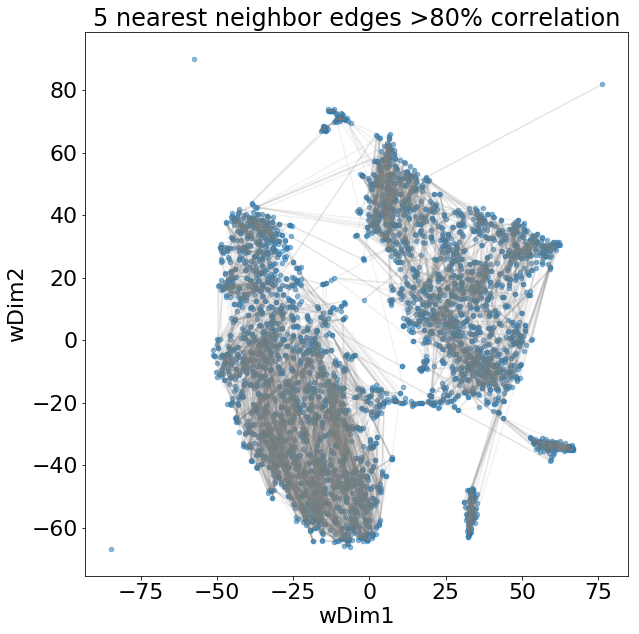

In [254]:
f,ax = plt.subplots()
for pair in pairs_wSE_80:
    xy1 = tsnedfSE.iloc[pair[0]][['wDim1','wDim2']]
    xy2 = tsnedfSE.iloc[pair[1]][['wDim1','wDim2']]
    ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.1
            ,c='gray')

tsnedf.plot.scatter('wDim1','wDim2',figsize=(10,10),ax=ax,alpha=.5)
#plt.yticks([]);plt.xticks([])
plt.title('5 nearest neighbor edges >80% correlation')
plt.gcf().subplots_adjust(right=0.88)
plt.show()
f.savefig('../leidenalg/Datasets/Darmanis_Brain/brain_edges_corr80p'+date+'.png')

---------------------------------------
Making list of edges with 95.0% correlation and up
Max 5 edges per cell.
Found 10012 edges.
---------------------------------------


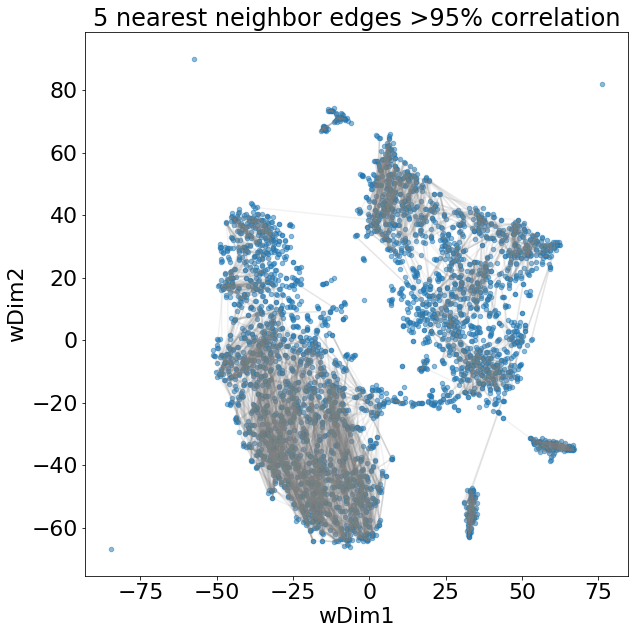

In [255]:
pairs_wSE_95 = li.make_pairs(pd.DataFrame(wdmSE),.05,5)
f,ax = plt.subplots()
for pair in pairs_wSE_95:
    xy1 = tsnedfSE.iloc[pair[0]][['wDim1','wDim2']]
    xy2 = tsnedfSE.iloc[pair[1]][['wDim1','wDim2']]
    ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.1
            ,c='gray')

tsnedf.plot.scatter('wDim1','wDim2',figsize=(10,10),ax=ax,alpha=.5)
#plt.yticks([]);plt.xticks([])
plt.title('5 nearest neighbor edges >95% correlation')
plt.gcf().subplots_adjust(right=0.88)
plt.show()
f.savefig('../leidenalg/Datasets/Darmanis_Brain/brain_edges_corr95p'+date+'.png')

In [100]:
# plot edge length vs correlation as scatter
# colored by inter or intra class edge 
wdmSEdf = pd.DataFrame(wdmSE)
pairs = li.make_pairs(wdmSEdf,2,5)
pairdf = pd.DataFrame(pairs)
for pair in pairdf.index:
    cell1 = pairdf.loc[pair,0]
    cell2 = pairdf.loc[pair,1]
    class1 = tsnedfSE.iloc[cell1]['new_membership']
    class2 = tsnedfSE.iloc[cell2]['new_membership']
    if class1==class2:
        pairdf.loc[pair,'edge_type'] = 'inter_class'
    else:
        pairdf.loc[pair,'edge_type'] = 'intra_class'
    pairdf.loc[pair,'correlation'] = 1 - wdmSEdf.loc[cell1,cell2]
    pairdf.loc[pair,'distance'] = wdmSEdf.loc[cell1,cell2]
    xy1 = tsnedf.iloc[cell1][['wDim1','wDim2']]
    xy2 = tsnedf.iloc[cell2][['wDim1','wDim2']]
    pairdf.loc[pair,'edge_length'] =  np.sqrt((xy2[0]-xy1[0])**2+(xy2[1]-xy1[1])**2)

---------------------------------------
Making list of edges with -100% correlation and up
Max 5 edges per cell.
Found 14380 edges.
---------------------------------------


In [101]:
pairdf.head()

0     1    edge_type  correlation  distance  edge_length
0  0  3135  inter_class     0.995003  0.004997     7.018144
1  0  3138  inter_class     0.994393  0.005607     8.110899
2  0  3136  inter_class     0.993078  0.006922     5.610688
3  0  3074  inter_class     0.993065  0.006935     3.272035
4  1  1382  intra_class     0.916742  0.083258     1.399987

In [102]:
pairdf.edge_type.value_counts()

inter_class    13788
intra_class      592
Name: edge_type, dtype: int64

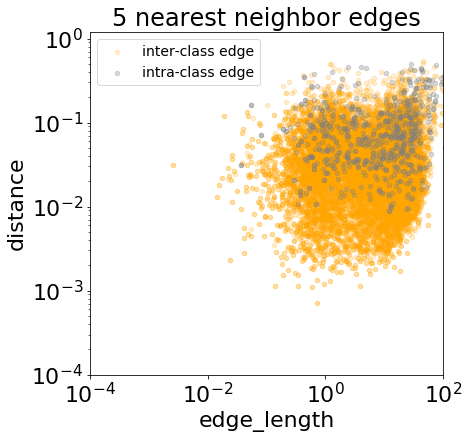

In [48]:
lut = {'inter_class':'orange','intra_class':'gray'}
cols = pairdf['edge_type'].map(lut)
f,ax = plt.subplots()
pairdf[pairdf['edge_type'].str.contains('inter')].plot.scatter('edge_length','distance',alpha=.2,figsize=(7,7),color='orange',label='inter-class edge',ax=ax)
pairdf[pairdf['edge_type'].str.contains('intra')].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color='gray',label='intra-class edge',ax=ax)
plt.yscale('log');plt.xscale('log')
plt.ylim(.0001,1.2)
plt.xlim(.0001,100)
plt.title('5 nearest neighbor edges')
plt.gcf().subplots_adjust(left=0.2,bottom=.2)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/dist_edgelength.png')

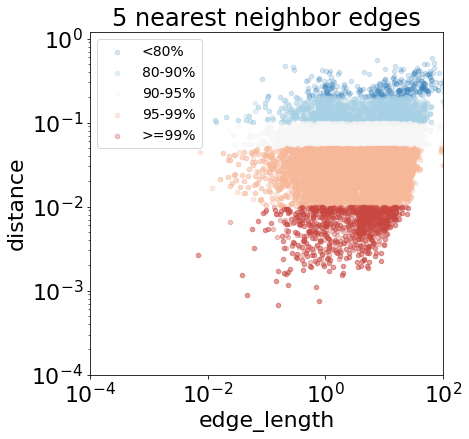

In [104]:
#lut = {'inter_class':'orange','intra_class':'gray'}
#cols = pairdf['edge_type'].map(lut)

f,ax = plt.subplots()
pairdf[pairdf['correlation']<.8].plot.scatter('edge_length','distance',alpha=.2,figsize=(7,7),color=colors[0],label='<80%',ax=ax)
pairdf[(pairdf['correlation']<.9)&(pairdf['correlation']>=.8)].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color=colors[1],label='80-90%',ax=ax)
pairdf[(pairdf['correlation']<.95)&(pairdf['correlation']>=.9)].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color=colors[2],label='90-95%',ax=ax)
pairdf[(pairdf['correlation']<.99)&(pairdf['correlation']>=.95)].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color=colors[3],label='95-99%',ax=ax)
pairdf[pairdf['correlation']>=.99].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color=colors[4],label='>=99%',ax=ax)
plt.yscale('log');plt.xscale('log')
plt.ylim(.0001,1.2)
plt.xlim(.0001,100)
plt.title('5 nearest neighbor edges')
plt.gcf().subplots_adjust(left=0.2,bottom=.2)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/dist_edgelength_corrcol.png')

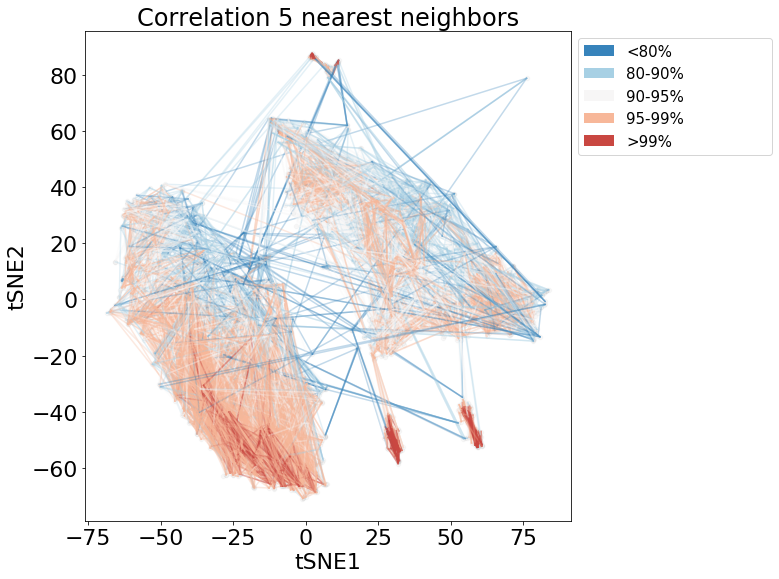

In [116]:
#pairs_wSE_95 = li.make_pairs(pd.DataFrame(wdmSE),.05,5)
colors = sns.color_palette('RdBu_r',5)
f,ax = plt.subplots(figsize=(10,10))
tsnedf.plot.scatter('wDim1','wDim2',figsize=(10,10),ax=ax,alpha=.05,color='gray')
for pair in pairdf.index:
    xy1 = tsnedfSE.iloc[pairdf.loc[pair,0]][['wDim1','wDim2']]
    xy2 = tsnedfSE.iloc[pairdf.loc[pair,1]][['wDim1','wDim2']]
    corr = pairdf.loc[pair,'correlation']
    if corr<.8:
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[0])
    elif (corr>=.8) & (corr<.9):
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[1])
    elif (corr>=.9) & (corr<.95):
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[2])
    elif (corr>=.95) & (corr<.99):
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[3])
    elif corr>=.99:
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[4])
#
#plt.yticks([]);plt.xticks([])
handles = ['<80%','80-90%','90-95%','95-99%','>99%']
labs = [f for f in colors]
dictcorr = dict(zip(handles,labs))
for x,y in dictcorr.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handle, labels = ax.get_legend_handles_labels()
    

plt.xlabel('tSNE1'),plt.ylabel('tSNE2')
plt.title('Correlation 5 nearest neighbors')
plt.legend(handle,handles, bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.gcf().subplots_adjust(right=0.8,bottom=.2)
plt.show()
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/brain_edges_corr_tsne'+date+'.png')

In [94]:
# investigate classification using sankey diagram. first massage data into right format
#tsnedfSE


In [212]:
def rgb_to_hex(list_vals):
    hexval=[]
    for r in list_vals:
        r *=255
        hexval.append('#%02X%02X%02X' % (int(round(r[0]*255)),int(round(r[1]*255)),int(round(r[2]*255))))
    return hexval

from collections import defaultdict

def sankey_BB(dataframe,**kwds):
    """
    necessary keywords:
    left_column, right_column,figure_name,savedir,close_plot
    """
    left_col = kwds['left_column']
    right_col = kwds['right_column']
    figname = kwds['figure_name']
    closePlot = kwds['close_plot']
    savedir = kwds['savedir']
    
    left = dataframe[left_col]
    right = dataframe[right_col]

    leftWeight = None
    rightWeight = None
    leftLabels = None
    rightLabels = None
    rightColor = False
    aspect = 20
    fontsize=20
    #figname = 'spyros_brain_noFetal_sankey_bot'
    figureName = figname

    keys = [str(f) for f in set(list(dataframe[left_col].unique())+list(dataframe[right_col].unique()))]
    keys = list(set(list(dataframe[left_col].unique())+list(dataframe[right_col].unique())))
    values=sns.color_palette('husl',len(keys))
    values_hex = rgb_to_hex(values)
    
    colors = dict(zip(keys,values_hex))
    colors[-1]='gray'
    colorDict = colors

    if leftWeight is None:
        leftWeight = []
    if rightWeight is None:
        rightWeight = []
    if leftLabels is None:
        leftLabels = []
    if rightLabels is None:
        rightLabels = []
    # Check weights
    if len(leftWeight) == 0:
        leftWeight = np.ones(len(left))

    if len(rightWeight) == 0:
        rightWeight = leftWeight

    plt.figure()
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')

    # Create Dataframe
    if isinstance(left, pd.Series):
        left = left.reset_index(drop=True)
    if isinstance(right, pd.Series):
        right = right.reset_index(drop=True)
    dataFrame = pd.DataFrame({'left': left, 'right': right, 'leftWeight': leftWeight,
                              'rightWeight': rightWeight}, index=range(len(left)))

    if len(dataFrame[(dataFrame.left.isnull()) | (dataFrame.right.isnull())]):
        raise NullsInFrame('Sankey graph does not support null values.')

    # Identify all labels that appear 'left' or 'right'
    allLabels = pd.Series(np.r_[dataFrame.left.unique(), dataFrame.right.unique()]).unique()

    # Identify left labels
    if len(leftLabels) == 0:
        leftLabels = pd.Series(dataFrame.left.unique()).unique()
    else:
        check_data_matches_labels(leftLabels, dataFrame['left'], 'left')

    # Identify right labels
    if len(rightLabels) == 0:
        rightLabels = pd.Series(dataFrame.right.unique()).unique()
    else:
        check_data_matches_labels(leftLabels, dataFrame['right'], 'right')
    # If no colorDict given, make one
    if colorDict is None:
        colorDict = {}
        palette = "hls"
        colorPalette = sns.color_palette(palette, len(allLabels))
        for i, label in enumerate(allLabels):
            colorDict[label] = colorPalette[i]
    else:
        missing = [label for label in allLabels if label not in colorDict.keys()]
        if missing:
            msg = "The colorDict parameter is missing values for the following labels : "
            msg += '{}'.format(', '.join(missing))
            raise ValueError(msg)

    # Determine widths of individual strips
    ns_l = defaultdict()
    ns_r = defaultdict()
    for leftLabel in leftLabels:
        leftDict = {}
        rightDict = {}
        for rightLabel in rightLabels:
            leftDict[rightLabel] = dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)].leftWeight.sum()
            rightDict[rightLabel] = dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)].rightWeight.sum()
        ns_l[leftLabel] = leftDict
        ns_r[leftLabel] = rightDict

    # Determine positions of left label patches and total widths
    leftWidths = defaultdict()
    leftLabels[::-1].sort()
    rightLabels[::-1].sort()
    rightLabels = rightLabels[[-1]+list(range(len(rightLabels)-1))]
    for i, leftLabel in enumerate(leftLabels):
        #print(leftLabel)
        myD = {}
        myD['left'] = dataFrame[dataFrame.left == leftLabel].leftWeight.sum()
        if i == 0:
            myD['bottom'] = 0
            myD['top'] = myD['left']
        else:
            myD['bottom'] = leftWidths[leftLabels[i - 1]]['top'] + 0.02 * dataFrame.leftWeight.sum()
            myD['top'] = myD['bottom'] + myD['left']
            topEdge = myD['top']
        leftWidths[leftLabel] = myD

    # Determine positions of right label patches and total widths
    rightWidths = defaultdict()
    for i, rightLabel in enumerate(rightLabels):
        myD = {}
        myD['right'] = dataFrame[dataFrame.right == rightLabel].rightWeight.sum()
        if i == 0:
            myD['bottom'] = 0
            myD['top'] = myD['right']
        else:
            myD['bottom'] = rightWidths[rightLabels[i - 1]]['top'] + 0.02 * dataFrame.rightWeight.sum()
            myD['top'] = myD['bottom'] + myD['right']
            topEdge = myD['top']
        rightWidths[rightLabel] = myD

    # Total vertical extent of diagram
    xMax = topEdge / aspect

    # Draw vertical bars on left and right of each  label's section & print label
    for leftLabel in leftLabels:
        plt.fill_between(
            [-0.02 * xMax, 0],
            2 * [leftWidths[leftLabel]['bottom']],
            2 * [leftWidths[leftLabel]['bottom'] + leftWidths[leftLabel]['left']],
            color=colorDict[leftLabel],
            alpha=0.99
        )
        plt.text(
            -0.05 * xMax,
            leftWidths[leftLabel]['bottom'] + 0.5 * leftWidths[leftLabel]['left'],
            leftLabel,
            {'ha': 'right', 'va': 'center'},
            fontsize=fontsize
        )
    for rightLabel in rightLabels:
        plt.fill_between(
            [xMax, 1.02 * xMax], 2 * [rightWidths[rightLabel]['bottom']],
            2 * [rightWidths[rightLabel]['bottom'] + rightWidths[rightLabel]['right']],
            color=colorDict[rightLabel],
            alpha=0.99
        )
        plt.text(
            1.05 * xMax,
            rightWidths[rightLabel]['bottom'] + 0.5 * rightWidths[rightLabel]['right'],
            rightLabel,
            {'ha': 'left', 'va': 'center'},
            fontsize=fontsize
        )

    # Plot strips
    for leftLabel in leftLabels:
        for rightLabel in rightLabels:
            labelColor = leftLabel
            if rightColor:
                labelColor = rightLabel
            if len(dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)]) > 0:
                # Create array of y values for each strip, half at left value,
                # half at right, convolve
                ys_d = np.array(50 * [leftWidths[leftLabel]['bottom']] + 50 * [rightWidths[rightLabel]['bottom']])
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_u = np.array(50 * [leftWidths[leftLabel]['bottom'] + ns_l[leftLabel][rightLabel]] + 50 * [rightWidths[rightLabel]['bottom'] + ns_r[leftLabel][rightLabel]])
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')

                # Update bottom edges at each label so next strip starts at the right place
                leftWidths[leftLabel]['bottom'] += ns_l[leftLabel][rightLabel]
                rightWidths[rightLabel]['bottom'] += ns_r[leftLabel][rightLabel]
                plt.fill_between(
                    np.linspace(0, xMax, len(ys_d)), ys_d, ys_u, alpha=0.65,
                    color=colorDict[labelColor]
                )
    plt.gca().axis('off')
    plt.gcf().set_size_inches(6, 18)
    if figureName != None:
        plt.savefig(savedir+"{}.png".format(figureName), bbox_inches='tight', dpi=150)
        plt.savefig(savedir+"{}.pdf".format(figureName), bbox_inches='tight', dpi=150)
    if closePlot:
        plt.close()

In [219]:
ts[5:].head()

wDim1      wDim2  class original_membership  \
Oligodendrocytes  60.552765 -47.058403      5                 NaN   
1001000173.G8     53.824368  21.808517      3          Neoplastic   
1001000173.D4     55.855118 -36.736149      5    Oligodendrocytes   
1001000173.B4     68.367439   4.812644      8          Neoplastic   
1001000173.A2     34.725250  -2.522209      9          Neoplastic   

                    new_membership      uDim1      uDim2  
Oligodendrocytes  Oligodendrocytes  45.995148 -49.315998  
1001000173.G8              Neurons  -0.704060  20.062088  
1001000173.D4     Oligodendrocytes  50.866665 -42.614632  
1001000173.B4            newClass3   4.370867  32.760307  
1001000173.A2            newClass4  36.380245  32.787090

In [220]:
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','spyros_classification_noFetal_selfEgdes_'+date
        ,'../leidenalg/Datasets/Darmanis_Brain/'+date+'/',True]
kw = dict(zip(keys,valu))
sankey_BB(ts[6:],**kw)

In [122]:
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','spyros_classification_noFetal_NoSelfEgdes'+date
        ,'../leidenalg/Datasets/Darmanis_Brain/',True]
kw = dict(zip(keys,valu))
#sankey_BB(tsnedf[8:],**kw)

In [117]:
matrix_feature_selected
tsnedf.groupby('new_membership').count()

#tsnedf

wDim1  wDim2  class  original_membership  uDim1  uDim2
new_membership                                                          
Astrocytes          100    100    100                   99    100    100
Endothelial          60     60     60                   59     60     60
Microglia             2      2      2                    1      2      2
Neurons              22     22     22                   21     22     22
OPC                   1      1      1                    0      1      1
Oligodendrocytes      1      1      1                    0      1      1
hybrid                3      3      3                    2      3      3
hybrids               2      2      2                    1      2      2
newClass1          1278   1278   1278                 1278   1278   1278
newClass2           790    790    790                  790    790    790
newClass3           551    551    551                  551    551    551
newClass4           532    532    532                  532    532    532
newClass5           162    162    162                  162    162    162
newClass6            82     82     82                   82     82     82
newClass7            11     11     11                   11     11     11

In [289]:
from scipy.spatial.distance import pdist, squareform
from fastcluster import linkage
from polo import optimal_leaf_ordering

def _optimal_order(data, **kwargs):
    """ Optimal leaf ordering
        **kwargs passed to pdist e.g. metric='correlation'
    """
    d = pdist(data, **kwargs)
    link = linkage(d, method='average')
    optimal_order = optimal_leaf_ordering(link, d)
    return optimal_order

def make_top_genes(feat_sel_matrix,tsne_df,column_name,numgenes):
    cols = tsne_df[column_name].unique()
    genes = pd.DataFrame(index=range(numgenes),columns=cols)
    class_exp = pd.DataFrame(index=feat_sel_matrix.index,columns=cols)
    genes_OD = genes.copy()
    gexp = genes.copy()
    for group in cols:
        members = tsne_df[tsne_df[column_name]==group].index
        class_exp[group] = feat_sel_matrix.loc[:, members].T.mean()
        # this takes the top expressing genes per class in the feature selected matrix
        genes[group] = feat_sel_matrix[members].mean(axis=1).sort_values(ascending=False)[:numgenes].index
        # this retrieves the overdispersed genes in a class, when compared to the average 
        """features = set()
        ge1 = feat_sel_matrix.loc[:, members]
        ge2 = (feat_sel_matrix.loc[:, :].sum(axis=1) - ge1).divide(len(feat_sel_matrix.T) - len(members))
        fold_change = np.log2(ge1 + 0.1) - np.log2(ge2 + 0.1)
        markers = np.argpartition(fold_change, -numgenes)[-numgenes:]
        genes_OD[group] = markers
        features |= set(markers)"""

    features = set()
    for group in cols:
        ge1 = class_exp[group]
        ge2 = (class_exp.sum(axis=1) - ge1).divide(len(class_exp.T) - 1)
        fold_change = np.log2(ge1 + 0.1) - np.log2(ge2 + 0.1)
        markers = np.argpartition(fold_change, -numgenes)[-numgenes:]
        markers = fold_change.sort_values()[-numgenes:]
        #print(markers.index)
        genes_OD[group] = markers
        features |= set(markers.index)
        
        
    unique_genes = set()
    for c in genes.columns:
        unique_genes |= set(genes[c])
    panel = pd.DataFrame(index=unique_genes,columns=cols)
    panel_OD = pd.DataFrame(index=features,columns=cols)
    for group in cols:
        members = tsne_df[tsne_df[column_name]==group].index
        panel[group] = feat_sel_matrix.loc[panel.index,members].mean(axis=1)
        panel_OD[group] = feat_sel_matrix.loc[panel_OD.index,members].mean(axis=1)
    return panel,panel_OD

def ordered_classes(panel):
    row_link = _optimal_order(panel.T.corr(), metric='correlation')
    col_link = _optimal_order(panel.corr(), metric='correlation')
    #cg = sns.clustermap(panel.T.corr(), row_linkage=row_link, col_linkage=row_link,figsize=(20,55),xticklabels=False)
    cg = sns.clustermap(np.log2(panel+0.001),row_linkage=row_link,col_linkage=col_link)
    plt.close()
    rows = cg.dendrogram_row.reordered_ind
    columns = cg.dendrogram_col.reordered_ind
    
    row_names = list(panel.iloc[rows].index)
    col_names = list(panel.T.iloc[columns].index)
    return row_names, col_names

def order_correlation_matrix(matrix):
    row_link = _optimal_order(matrix, metric='correlation')
    cg = sns.clustermap(matrix,row_linkage=row_link,col_linkage=col_link)
    plt.close()
    rows = cg.dendrogram_row.reordered_ind
    row_names = list(matrix.iloc[rows].index)
    return row_names

def plot_dot(panel,rows,columns,**kwds):
    figname = kwds['figure_name']
    savedir = kwds['savedir']
    xgrid = list(range(len(panel.columns)))
    ygrid = list(range(40))
    import get_timestamp as time
    date = time.ymd()
    f = plt.figure(figsize=(20,50))
    i=0
    for gene in panel.loc[rows].index:
        temp = panel[panel.index==gene].loc[:,columns]
        #temp = sizes[sizes.index==gene].iloc[:,columnz].multiply(10)
        plt.scatter(xgrid,np.ones(len(xgrid))*i,s=temp.divide(1),alpha=.5)
        i+=1
    plt.yticks(np.arange(len(panel)),rows)
    plt.xticks(np.arange(len(panel.T)),columns,rotation=90)
    f.savefig(savedir+'dotplot_'+figname+'.png')
    plt.close()
    
def make_dotplot(feat_sel_matrix,tsne_df,numgenes,**kwargs):
    column_name = kwargs['right_column']
    gene_panel,panel_overdisp = make_top_genes(feat_sel_matrix,tsne_df,column_name,numgenes)
    r,c = ordered_classes(gene_panel)
    rOD,cOD = ordered_classes(panel_overdisp)
    kwargs['figure_name'] = kwargs['figure_name']+'_topExpressing_'
    plot_dot(gene_panel,r,c,**kwargs)
    kwargs['figure_name'] = kwargs['figure_name']+'_overdispersed_'
    plot_dot(panel_overdisp,rOD,cOD,**kwargs)
    return gene_panel,r,c
    

In [153]:
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','spyros_classification_noFetal_NoSelfEgdes_top5_'
        ,'../leidenalg/Datasets/Darmanis_Brain/',True]
kw = dict(zip(keys,valu))
genePanel5,ro5,co5 = make_dotplot(matrix_feature_selected,tsnedf,5,**kw)

In [139]:
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','spyros_classification_noFetal_NoSelfEgdes_newcells_'
        ,'../leidenalg/Datasets/Darmanis_Brain/',True]
kw = dict(zip(keys,valu))
genePanelNC,roNC,coNC = make_dotplot(matrix_feature_selected.iloc[:,8:],tsnedf[8:],20,**kw)
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','spyros_classification_noFetal_NoSelfEgdes_atlascells_'
        ,'../leidenalg/Datasets/Darmanis_Brain/',True]
kw = dict(zip(keys,valu))
genePanelOC,roOC,coOC = make_dotplot(matrix_feature_selected.iloc[:,:8],tsnedf[:8],20,**kw)

In [290]:
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','spyros_classification_SelfEgdes'
        ,'../leidenalg/Datasets/Darmanis_Brain/'+date+'/',True]
kw = dict(zip(keys,valu))
genePanelSE,roSE,coSE = make_dotplot(matrix_feature_selected,ts,10,**kw)

In [236]:
top,od = make_top_genes(matrix_feature_selected,ts,'new_membership',20)

/home/bojk/miniconda3/envs/py360/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [284]:
cols = ts['new_membership'].unique()
genes = pd.DataFrame(index=range(10),columns=cols)
class_exp = pd.DataFrame(index=matrix_feature_selected.index,columns=cols)
genes_OD = genes.copy()

for group in cols:
    members = ts[ts['new_membership']==group].index
    class_exp[group] = matrix_feature_selected.loc[:, members].T.mean()
features = set()
for group in cols:
    ge1 = class_exp[group]
    ge2 = (class_exp.sum(axis=1) - ge1).divide(len(class_exp.T) - 1)
    fold_change = np.log2(ge1 + 0.1) - np.log2(ge2 + 0.1)
    markers = np.argpartition(fold_change, -20)[-20:]
    markers = fold_change.sort_values()[-10:]
    #print(markers.index)
    genes_OD[group] = markers
    features |= set(markers.index)

In [285]:
len(features)

129

In [281]:
fold_change.sort_values()

PLP1           -14.521597
CCL4           -14.394880
APOE           -14.342872
A2M            -14.209226
SPARCL1        -14.204254
C3             -14.157151
RGS1           -14.075998
MBP            -14.052485
APOD           -13.722545
CCL3           -13.406653
SPP1           -13.272490
FN1            -13.257417
CPE            -13.256624
IL8            -13.172144
IL1B           -12.960562
SLC11A1        -12.779687
DCN            -12.613236
CCL2           -12.525790
TF             -12.499922
THBS1          -12.436051
PTGDS          -12.381541
ACSL1          -12.334786
RNASE1         -12.317706
FCGBP          -12.285905
TGFBI          -12.083523
SERPINE1       -11.926854
PLTP           -11.913220
COL1A2         -11.861888
HLA-DRA        -11.661480
HSPA6          -11.584501
                  ...    
GPSM2            1.796782
SNAP29           1.857313
DNAH11           1.981594
COL4A5           2.027021
HPGDS            2.110941
TUBA1A           2.124576
KIF18A           2.160173
SDPR        

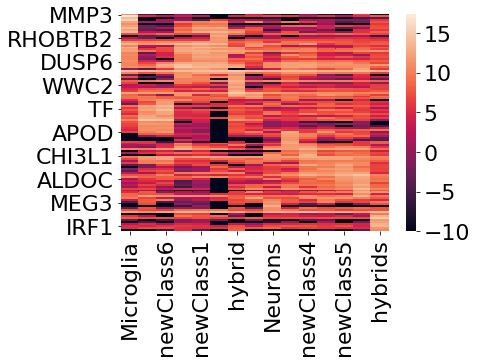

In [82]:
rows = cg.dendrogram_row.reordered_ind
columnz = cg.dendrogram_col.reordered_ind
sns.heatmap(np.log2(panel+0.001).iloc[rows,columnz])

In [149]:
xgrid

[0, 1, 2, 3, 4, 5, 6, 7]

/home/bojk/miniconda3/envs/py360/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys
/home/bojk/miniconda3/envs/py360/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]


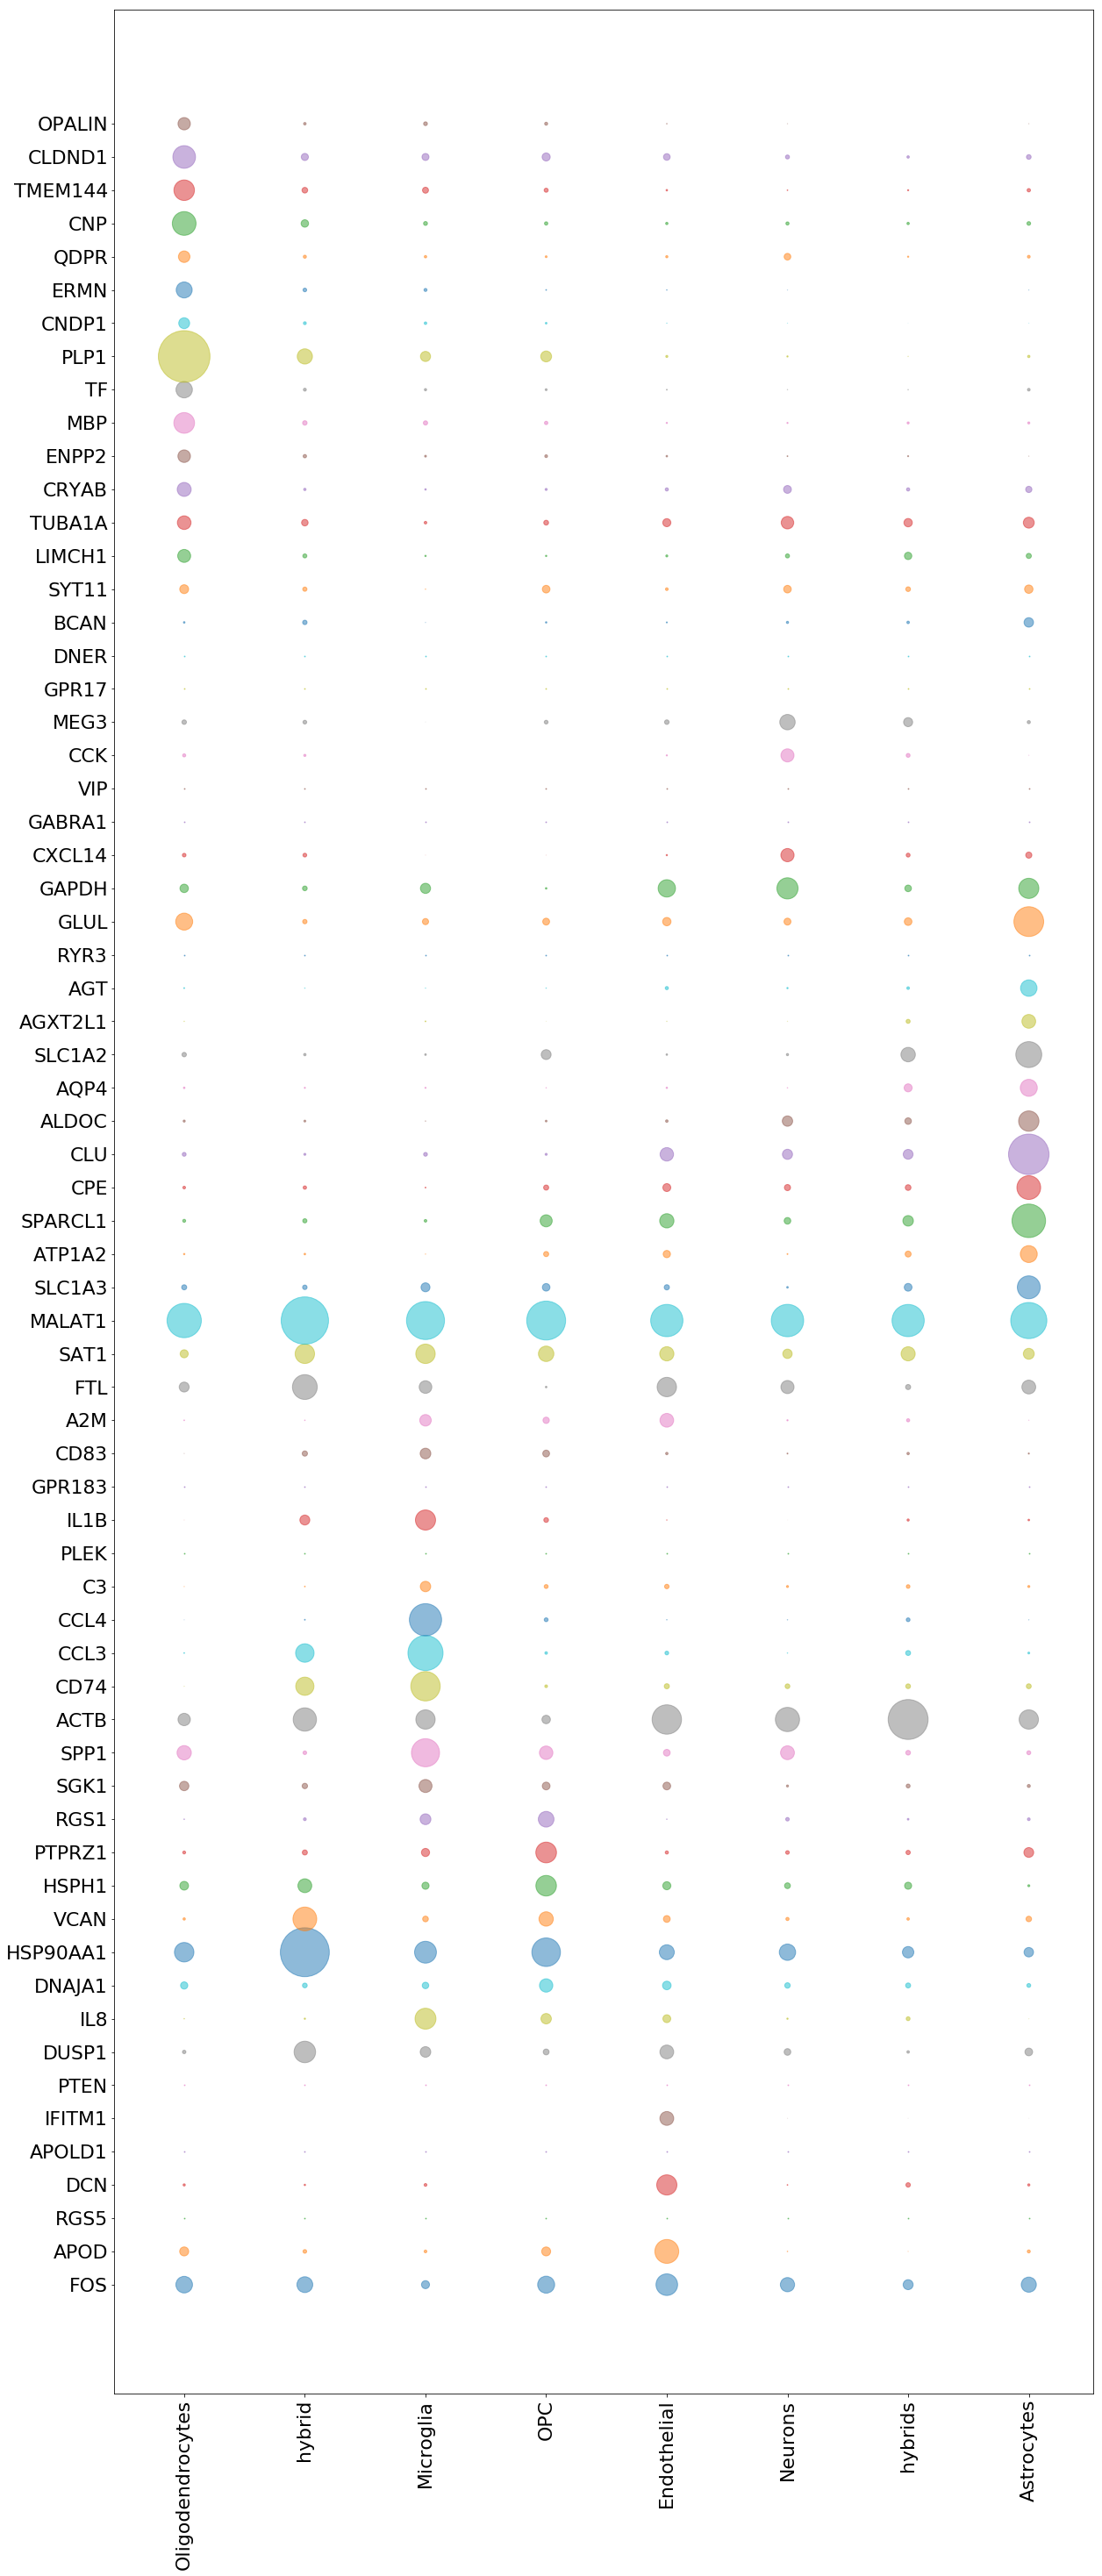

In [150]:

xgrid = list(range(len(coOC)))
ygrid = list(range(len(roOC)))

f = plt.figure(figsize=(20,50))
i=0
for gene in panel.loc[roOC].index:
    temp = panel[panel.index==gene].loc[:,coOC]
    #temp = sizes[sizes.index==gene].iloc[:,columnz].multiply(10)
    plt.scatter(xgrid,np.ones(len(xgrid))*i,s=temp.divide(10),alpha=.5)
    i+=1

plt.yticks(np.arange(len(ygrid)),panel.loc[roOC].index)
plt.xticks(np.arange(len(xgrid)),panel.T.loc[coOC].index,rotation=90
          )
plt.show()
f.savefig('../leidenalg/Datasets/Darmanis_Brain/dotplot_semiAnnotate_atlasCells_noSelfedges'+date+'.png')

In [116]:
#perform hierarchical clustering on heatmap 
tsnedf
matrix_feature_selected[matrix_feature_selected.index=='CIT']#.T.sort_values('CIT')

Astrocytes  Endothelial  Microglia     Neurons        OPC  \
CIT   12.069619    36.300635  16.513174  385.904437  52.973862   

     Oligodendrocytes     hybrid     hybrids  1001000173.G8  1001000173.D4  \
CIT         40.073169  83.666911  500.980004            0.0            0.0   

     ...  1001000271.C2  1001000271.D1  1001000271.B1  1001000271.A3  \
CIT  ...            0.0            0.0            0.0            0.0   

     1001000271.E1  1001000271.F1  1001000271.D4  1001000271.C1  \
CIT            0.0            0.0            0.0            0.0   

     1001000271.H7  1001000271.H2  
CIT            0.0            0.0  

[1 rows x 3597 columns]

In [114]:
matrix_feature_selected['1001000238.E7'].sort_values()
matrix_feature_selected.max().max()

437879.44132966193

In [155]:
BA_meta.Cell_type.value_counts()

Neurons             131
Astrocytes           62
Oligodendrocytes     38
hybrid               24
hybrids              22
Endothelial          20
OPC                  18
Microglia            16
Name: Cell_type, dtype: int64

In [180]:
pd.pivot_table(index=tsnedf.index,columns=tsnedf['new_membership'].unique(),values=tsnedf['new_membership'])

TypeError: pivot_table() missing 1 required positional argument: 'data'

In [223]:
import collections
newdf = tsnedf[8:].copy()
newdf['class'] = newdf['class']+.1
cardf = pd.pivot_table(newdf,values='class',index=newdf.index,columns='new_membership',aggfunc=np.count_nonzero).fillna(0).T.corr()
#ordered_idx = order_correlation_matrix(cardf)


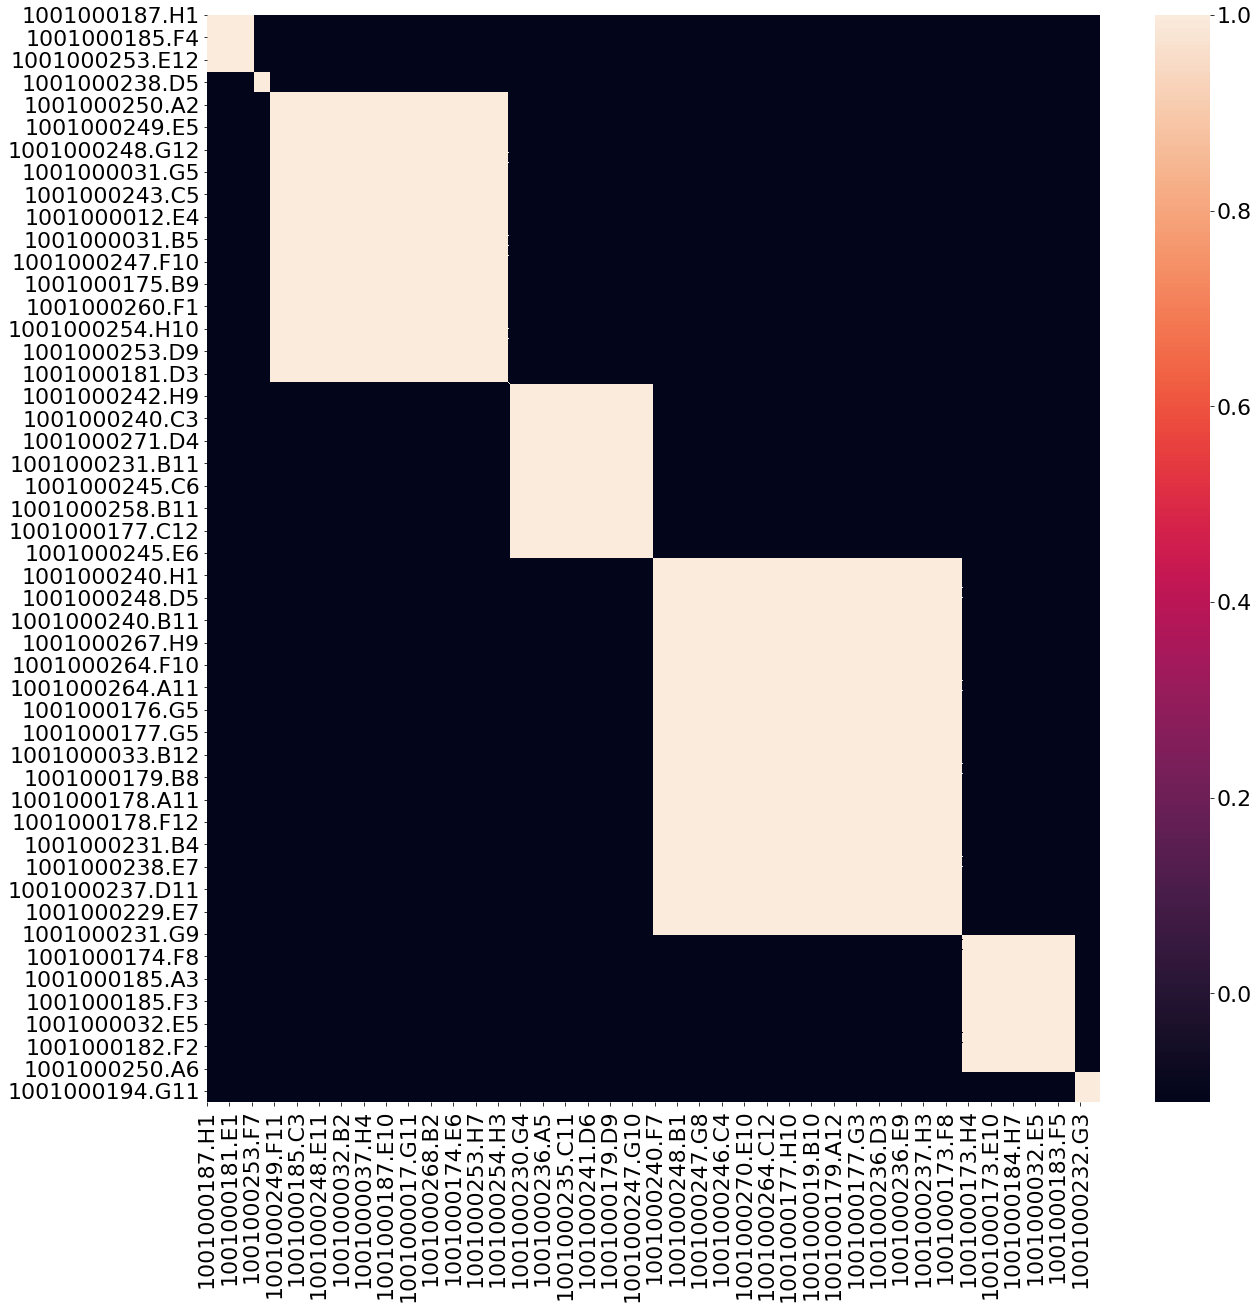

In [225]:
ordered_idx = newdf['new_membership'].sort_values().index
f=  plt.figure(figsize=(20,20))
sns.heatmap(cardf.loc[ordered_idx,ordered_idx])

In [226]:
newdf['new_membership'].value_counts()
#tsnedf['class'].value_counts()


newClass1           1243
Neurons              959
hybrid               575
newClass2            453
Astrocytes           190
newClass3             97
Endothelial           65
OPC                    4
hybrids                2
Oligodendrocytes       1
Name: new_membership, dtype: int64

In [221]:
tsnedf[tsnedf['new_membership'].str.contains('ligoden')]
tsnedf[tsnedf['new_membership'].str.contains('OPC')]

wDim1      wDim2  class original_membership  \
OPC            -12.430294  25.147661    4.3                 NaN   
1001000175.H9  -14.078488  23.811340    4.3              Neuron   
1001000175.G10 -14.071210  23.804029    4.3          Neoplastic   
1001000179.B12 -10.305135  17.561520    4.3          Neoplastic   
1001000259.G4  -14.488623  23.684746    4.3         Immune cell   

               new_membership      uDim1      uDim2  
OPC                       OPC  44.990341  25.802475  
1001000175.H9             OPC  20.816017  42.374783  
1001000175.G10            OPC  -9.731712  51.762283  
1001000179.B12            OPC  -1.758823  50.203178  
1001000259.G4             OPC  -4.238031  50.717274

In [222]:
tsnedf['original_membership'].value_counts()

Immune cell        1847
Neoplastic         1091
OPC                 406
Astocyte             88
Oligodendrocyte      85
Vascular             51
Neuron               21
Name: original_membership, dtype: int64

In [501]:
newdf2 = None
newdf2 = tsnedfSE.copy()
newdf2['class2'] = newdf['class']+1
df = pd.pivot_table(newdf2,values='class2',index=newdf2.index,columns='original_membership',aggfunc=np.count_nonzero).fillna(0).copy()                     

In [510]:
df#.T.corr()
a = df.T.corr().values

In [483]:
df.T.sum().var()

0.0

In [647]:
a

array([[ 1.        ,  1.        ,  1.        , ..., -0.07142857,
        -0.07142857, -0.07142857],
       [ 1.        ,  1.        ,  1.        , ..., -0.07142857,
        -0.07142857, -0.07142857],
       [ 1.        ,  1.        ,  1.        , ..., -0.07142857,
        -0.07142857, -0.07142857],
       ...,
       [-0.07142857, -0.07142857, -0.07142857, ...,  1.        ,
        -0.07142857, -0.07142857],
       [-0.07142857, -0.07142857, -0.07142857, ..., -0.07142857,
         1.        , -0.07142857],
       [-0.07142857, -0.07142857, -0.07142857, ..., -0.07142857,
        -0.07142857,  1.        ]])

In [646]:
imp.reload(li)


TypeError: 'str' object does not support item assignment

In [652]:
#ts

In [635]:
average_df = pd.DataFrame(np.average(b,axis=0),index=df.index,columns=df.index)

#sns.heatmap(average_df)


In [640]:
stablep.sum()#.value_counts()

1001000010.B4     724.0
1001000010.B5     724.0
1001000010.C1      42.0
1001000010.C5      42.0
1001000010.C8     356.0
1001000010.D5      42.0
1001000010.D9      81.0
1001000010.E8     356.0
1001000010.F1     356.0
1001000010.F10    356.0
1001000010.F7      41.0
1001000010.F8     356.0
1001000010.G2     724.0
1001000010.G3      20.0
1001000010.H3     356.0
1001000012.A1     602.0
1001000012.A10    244.0
1001000012.A11    244.0
1001000012.A12    602.0
1001000012.A2      67.0
1001000012.A3      10.0
1001000012.A4     602.0
1001000012.A5     602.0
1001000012.A6     602.0
1001000012.A7      28.0
1001000012.A8     602.0
1001000012.A9     602.0
1001000012.B1      28.0
1001000012.B10     67.0
1001000012.B11    602.0
                  ...  
1001000270.B4     724.0
1001000270.C1     724.0
1001000270.D1     724.0
1001000270.D12    410.0
1001000270.D7     129.0
1001000270.D9      19.0
1001000270.E10    724.0
1001000270.E12    724.0
1001000270.F10    724.0
1001000270.G1     724.0
1001000270.G3   

In [604]:
idxs

['1001000178.D9',
 '1001000230.G11',
 '1001000235.G10',
 '1001000238.H7',
 '1001000240.E7',
 '1001000241.A10',
 '1001000241.C9',
 '1001000267.H9']

In [572]:
average_df[average_df[average_df==1].sum().sort_values()==1]

/home/bojk/miniconda3/envs/py360/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


1001000010.B4  1001000010.B5  1001000010.C1  1001000010.C5  \
1001000031.C8               0.0            0.0            0.0            0.0   
1001000031.E4               0.0            0.0            0.0            0.0   
1001000031.G7               0.0            0.0            0.0            0.0   
1001000037.A1               0.0            0.0            0.0            0.0   
1001000037.D1               0.0            0.0            0.0            0.0   
1001000037.G10              0.0            0.0            0.0            0.0   
1001000173.B2               0.0            0.0            0.0            0.0   
1001000173.G6               0.0            0.0            0.0            0.0   
1001000174.C6               0.0            0.0            0.0            0.0   
1001000174.E12              0.0            0.0            0.0            0.0   
1001000175.D9               0.0            0.0            0.0            0.0   
1001000178.B3               0.0            0.0            0.0            0.0   
1001000179.F10              0.6            0.6            0.2            0.2   
1001000181.B4               0.0            0.0            0.0            0.0   
1001000181.F9               0.4            0.4            0.2            0.2   
1001000182.B12              0.0            0.0            0.0            0.0   
1001000182.H11              0.0            0.0            0.0            0.0   
1001000183.D10              0.0            0.0            0.0            0.0   
1001000183.E9               0.0            0.0            0.0            0.0   
1001000184.A7               0.0            0.0            0.0            0.0   
1001000184.E2               0.0            0.0            0.0            0.0   
1001000185.D3               0.0            0.0            0.0            0.0   
1001000185.E1               0.0            0.0            0.0            0.0   
1001000229.A3               0.6            0.6            0.4            0.4   
1001000229.E8               0.2            0.2            0.6            0.6   
1001000230.E1               0.0            0.0            0.0            0.0   
1001000230.F9               0.0            0.0            0.0            0.0   
1001000230.G2               0.2            0.2            0.0            0.0   
1001000233.A6               0.2            0.2            0.0            0.0   
1001000233.D10              0.0            0.0            0.0            0.0   
...                         ...            ...            ...            ...   
1001000241.C7               0.2            0.2            0.2            0.2   
1001000242.F1               0.0            0.0            0.0            0.0   
1001000245.B3               0.0            0.0            0.0            0.0   
1001000246.A8               0.0            0.0            0.0            0.0   
1001000246.D5               0.0            0.0            0.0            0.0   
1001000246.E6               0.8            0.8            0.4            0.4   
1001000247.H11              0.0            0.0            0.0            0.0   
1001000250.A6               0.0            0.0            0.0            0.0   
1001000250.C10              0.0            0.0            0.0            0.0   
1001000250.C5               0.0            0.0            0.0            0.0   
1001000250.E2               0.0            0.0            0.0            0.0   
1001000253.E9               0.0            0.0            0.0            0.0   
1001000254.E7               0.0            0.0            0.0            0.0   
1001000258.C12              0.0            0.0            0.0            0.0   
1001000258.C8               0.0            0.0            0.0            0.0   
1001000258.C9               0.0            0.0            0.0            0.0   
1001000258.D2               0.0            0.0            0.0            0.0   
1001000259.C1               0.0            0.0            0.0            0.0   
1001000259.H3     